***Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.***

***Importing Skin Cancer Data***

**Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
!pip install keras

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
root_path = '/content/gdrive/MyDrive/cnn'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

***Create a dataset***

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


***Visualize the data***

Todo, create a code to visualize one instance of all the nine classes present in the dataset

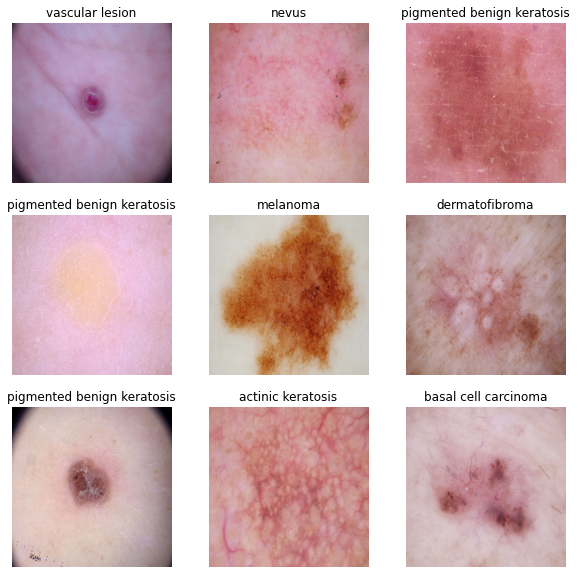

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

***Create the model***

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

***Compile the model***

**Choose an appropirate optimiser and loss function for model training**

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        4

***Train the model***

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 523s 2s/step - loss: 1.9380 - accuracy: 0.2818 - val_loss: 1.8498 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7387 - accuracy: 0.3521 - val_loss: 1.6521 - val_accuracy: 0.3714
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5836 - accuracy: 0.4235 - val_loss: 1.5476 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5664 - accuracy: 0.4358 - val_loss: 1.5107 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4964 - accuracy: 0.4621 - val_loss: 1.5833 - val_accuracy: 0.4116
Epoch 6/20
56/56 [==============================] - 2s 33ms/step - loss: 1.4771 - accuracy: 0.4727 - val_loss: 1.4775 - val_accuracy: 0.4452
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.4166 - accuracy: 0.5006 - val_loss: 1.5353 - val_accuracy: 0.4922
Epoch 8/20
56/56 [======

***Visualizing training results***

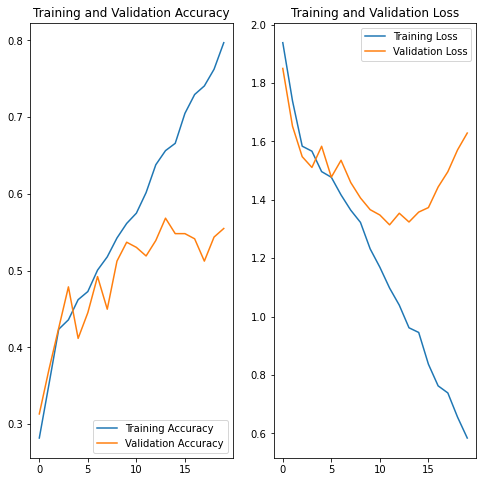

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit***
The models are severely overfitted with training accuracy very high and validation accuracy very low

training accuracy is about 79 percent however validation accuracy is 55% as per the graph.
training loss decreased and validation loss increased

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.4),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

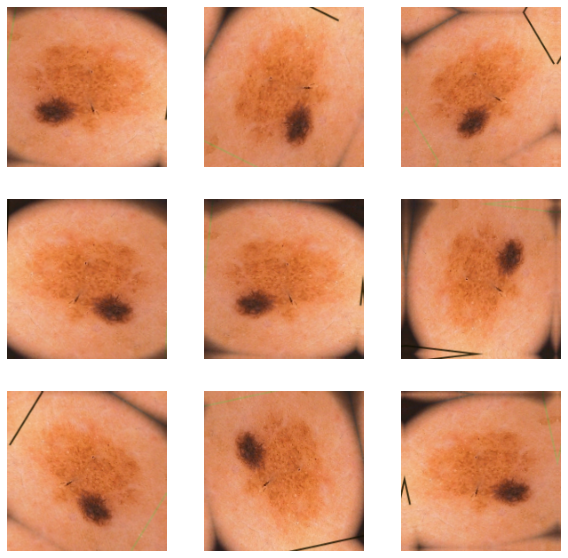

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images,labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

***Todo: Create the model, compile and train the model***

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model_aug_drop = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

***Compiling the model***

In [20]:
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


***Training the model***

In [21]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model_aug_drop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 45ms/step - loss: 1.9238 - accuracy: 0.2807 - val_loss: 1.7719 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6441 - accuracy: 0.3912 - val_loss: 1.5885 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5442 - accuracy: 0.4330 - val_loss: 1.4976 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4738 - accuracy: 0.4743 - val_loss: 1.4196 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.3938 - accuracy: 0.5033 - val_loss: 1.4790 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3596 - accuracy: 0.5117 - val_loss: 1.4017 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3218 - accuracy: 0.5212 - val_loss: 1.3885 - val_accuracy: 0.5436
Epoch 8/20
56

***Visualizing the results***

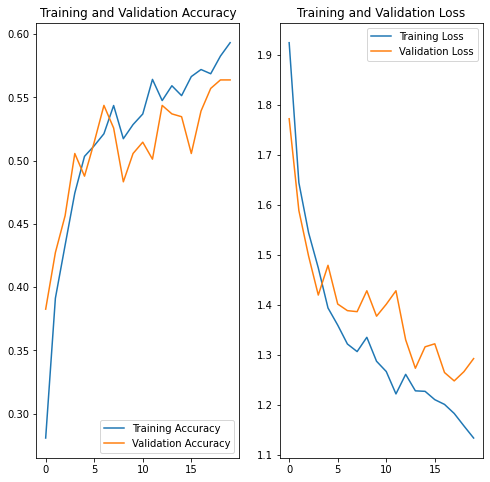

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Todo:*** W**rite your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**
After augmentation and dropout, the model fitting has improved tremendously. overfits not there.the accruacy is still around 60 and 55 for training and test set. its like underfitting.

This might be due to lower number of training data available

***Todo***: Find the distribution of classes in the training dataset.
***Context***: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
dic ={'Cancer_type':[],'Data_available':[]}

for name in class_names:
    a = name+'/*'
    n = len(list(data_dir_train.glob(a)))
    dic['Cancer_type'].append(name)
    dic['Data_available'].append(n)
cancer = pd.DataFrame.from_dict(dic)
cancer.sort_values(by='Data_available',ascending=False)

,Cancer_type,Data_available
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


***Todo : Write your findings here:
- Which class has the least number of samples?
seborrheic keratosis

- Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis

Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.***

In [24]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:
*   Instantiate a Pipeline object pointing to a directory containing your initial image data set.
*  Define a number of operations to perform on this data set using your Pipeline object.
*   Execute these operations by calling the Pipeline’s sample() method.







In [25]:
path_to_training_dataset="/content/gdrive/MyDrive/cnn/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1093C7F150>: 100%|██████████| 500/500 [00:20<00:00, 23.98 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1093C3FC50>: 100%|██████████| 500/500 [00:21<00:00, 23.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F11A4481810>: 100%|██████████| 500/500 [00:22<00:00, 22.73 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7F1093CB8090>: 100%|██████████| 500/500 [01:42<00:00,  4.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F1093C1F190>: 100%|██████████| 500/500 [01:38<00:00,  5.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1093C1CED0>: 100%|██████████| 500/500 [00:21<00:00, 22.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F110039A650>: 100%|██████████| 500/500 [00:49<00:00, 10.15 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F110D5BC510>: 100%|██████████| 500/500 [00:20<00:00, 24.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1093C2FF90>: 100%|██████████| 500/500 [00:20<00:00, 24.16 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [27]:
import glob

In [28]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/cnn/Train/vascular lesion/output/vascular lesion_original_ISIC_0031276.jpg_a72f590c-22c2-4951-b3cc-741b1c1e76d4.jpg',
 '/content/gdrive/MyDrive/cnn/Train/vascular lesion/output/vascular lesion_original_ISIC_0027937.jpg_8d0b7854-ab36-47f0-81d9-9cb704e6d8c4.jpg',
 '/content/gdrive/MyDrive/cnn/Train/vascular lesion/output/vascular lesion_original_ISIC_0027256.jpg_1cac54cd-a906-42b0-8dfb-76d234de29ae.jpg',
 '/content/gdrive/MyDrive/cnn/Train/vascular lesion/output/vascular lesion_original_ISIC_0029608.jpg_0d8fa25d-df89-4b03-b17e-50c3240e55ce.jpg',
 '/content/gdrive/MyDrive/cnn/Train/vascular lesion/output/vascular lesion_original_ISIC_0025807.jpg_78232a6d-73ba-49dc-ace8-4f4736bb111d.jpg',
 '/content/gdrive/MyDrive/cnn/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_a67c07ab-a31e-4f18-abd6-2deff474d46c.jpg',
 '/content/gdrive/MyDrive/cnn/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_b4126b81-440a-45de-8e87-8ac5d97981a

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df_x = pd.DataFrame(df2['Label'].value_counts().reset_index().rename(columns={"index": "Cancer_type", "Label": "Data_available"}))
new_df = df_x+cancer

In [32]:
# New data frame with old and appended values 
new_df

,Cancer_type,Data_available
0,vascular lesionactinic keratosis,614
1,squamous cell carcinomabasal cell carcinoma,876
2,seborrheic keratosisdermatofibroma,595
3,nevusmelanoma,938
4,melanomanevus,857
5,actinic keratosispigmented benign keratosis,962
6,dermatofibromaseborrheic keratosis,577
7,pigmented benign keratosissquamous cell carcinoma,681
8,basal cell carcinomavascular lesion,639


**So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.**

***Todo: Train the model on the data created using Augmentor***

In [33]:
batch_size = 32
img_height = 180
img_width = 180

***Todo: Create a training dataset***

In [34]:
data_dir_train="/content/gdrive/MyDrive/cnn/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


***Todo: Create a validation dataset***

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


***Todo: Create your model (make sure to include normalization)***

In [36]:
model_aug_drop = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

***Todo: Compile your model (Choose optimizer and loss function appropriately)***

In [37]:
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

***Todo: Train your model***

In [38]:
epochs = 30
history = model_aug_drop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 41s 224ms/step - loss: 1.7973 - accuracy: 0.2973 - val_loss: 1.8636 - val_accuracy: 0.2992
Epoch 2/30
169/169 [==============================] - 39s 222ms/step - loss: 1.5395 - accuracy: 0.4008 - val_loss: 1.4485 - val_accuracy: 0.4402
Epoch 3/30
169/169 [==============================] - 38s 216ms/step - loss: 1.4214 - accuracy: 0.4462 - val_loss: 1.3232 - val_accuracy: 0.4788
Epoch 4/30
169/169 [==============================] - 39s 224ms/step - loss: 1.3486 - accuracy: 0.4842 - val_loss: 1.3093 - val_accuracy: 0.4996
Epoch 5/30
169/169 [==============================] - 39s 223ms/step - loss: 1.3220 - accuracy: 0.4961 - val_loss: 1.2751 - val_accuracy: 0.5041
Epoch 6/30
169/169 [==============================] - 38s 217ms/step - loss: 1.2763 - accuracy: 0.5087 - val_loss: 1.2699 - val_accuracy: 0.5078
Epoch 7/30
169/169 [==============================] - 39s 221ms/step - loss: 1.2685 - accuracy: 0.5076 - val_loss: 1.2591 - val_ac

***Todo: Visualize the model results***

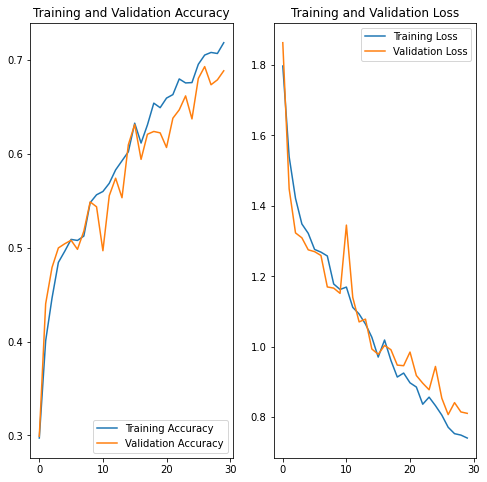

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?***
class imbalance solve the underfitting as training accuracy is above 70 percent and also solve underfitting as validation accuracy also near about 70 percent.
the model is improved here, class rebalance really helped in improving the accuracy.